# Fine-Tuning no ICDAR 2019 - Approach 2

## Abordagem usando um lr adaptável obtido pelo otimizador adafactor

## Enunciado

O objetivo deste exercício é treinar uma rede similar à da aula 7 (CNN como codificadora + decodificador do transformer) mas tendo como entrada imagens de recibos reais. A saída esperada é o nome da compania e seu endereço. 

Iremos usar o [dataset SROIE da competição ICDAR 2019.](https://rrc.cvc.uab.es/?ch=13&com=introduction)

Métricas: usar o código abaixo para calcular o exact match da resposta toda e F1 de palavras.

In [1]:
version = "finetuning_adlr_augm_extract_app1_adafactor_seqred_test3" #@param {type: "string"}
lr =  1e-3#@param {type: "number"}
bs =    12#@param {type: "integer"} 
accum = 6#@param {type: "integer"}
seq_len =  64#@param {type: "integer"}
patience =  10#@param {type: "integer"}
max_epochs =  500#@param {type: "integer"}
dropout_rate = 0.5#@param {type: "number"}
drop_connect_rate = 0.5#@param {type: "number"}
debug = False #@param {type: "boolean"}


# Define hyperparameters
hparams = {"version": version,
           "lr": lr,
           "bs": bs,
           "accum": accum,
           "seq_len": seq_len,
           "patience": patience,
           "max_epochs": max_epochs,
           "dropout_rate": dropout_rate,
           "drop_connect_rate": drop_connect_rate,
           "debug": debug, 
           "enet": "efficientnet-b0",
           "t5": "t5-small"}
hparams             

{'version': 'finetuning_adlr_augm_extract_app1_adafactor_seqred_test3',
 'lr': 0.001,
 'bs': 12,
 'accum': 6,
 'seq_len': 64,
 'patience': 10,
 'max_epochs': 500,
 'dropout_rate': 0.5,
 'drop_connect_rate': 0.5,
 'debug': False,
 'enet': 'efficientnet-b0',
 't5': 't5-small'}

## Download do dataset

In [2]:
# !gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula8/dataset_sroie_icdar_2019.zip .
# !unzip dataset_sroie_icdar_2019.zip

O dataset contém 626 imagens e suas respectiva anotações (respostas), sendo 200 imagens separadas para teste. Cada imagem tem um arquivo txt correspondente que contém as respostas em formato json.

In [3]:
# !mkdir "output"

In [4]:
import os
import numpy as np
import shutil
import random
import glob

In [5]:
# # # Creating Train / Val / Test folders (One time use)
# root_dir = 'output'
# mode = 'train'
# val_ratio = 0.25
# src_dir = 'train'

# os.makedirs(root_dir +'/train')
# os.makedirs(root_dir +'/val')

# allFileNames = glob.glob(f"{mode}/*.txt")
# np.random.shuffle(allFileNames)
# train_FileNames, val_FileNames = np.split(np.array(allFileNames),
#                                                 [int(len(allFileNames)* (1 - val_ratio))])


# train_FileNames = [name for name in train_FileNames.tolist()]
# val_FileNames = [name for name in val_FileNames.tolist()]

# print('Total images: ', len(allFileNames))
# print('Training: ', len(train_FileNames))
# print('Validation: ', len(val_FileNames))

# # Copy-pasting images
# for name in train_FileNames:
#     shutil.copy(name, root_dir +'/train')
#     shutil.copy(name[:-4]+'.jpg', root_dir +'/train')

# for name in val_FileNames:
#     shutil.copy(name, root_dir +'/val')
#     shutil.copy(name[:-4]+'.jpg', root_dir +'/val')


In [6]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from efficientnet_pytorch import EfficientNet
import json
import gc
from fairseq.optim import adafactor
import cv2
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Lambda, ToTensor, Compose
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from transformers import T5Tokenizer, T5ForConditionalGeneration
import sacrebleu
from pytorch_lightning.loggers.neptune import NeptuneLogger

In [7]:
data_json = json.load(open("train/X00016469612.txt"))
print(data_json)

print(data_json["company"])
print(data_json["address"])

{'company': 'BOOK TA .K (TAMAN DAYA) SDN BHD', 'date': '25/12/2018', 'address': 'NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.', 'total': '9.00'}
BOOK TA .K (TAMAN DAYA) SDN BHD
NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.


In [8]:
TOKENIZER = T5Tokenizer.from_pretrained(hparams['t5'])

extra_tokens = ['[NL]'] # Add token de 'nova linha' para multiline
added_tokens = []
for tok in extra_tokens:
  enc = TOKENIZER.encode(tok)
  if 2 in enc:
      added_tokens.append(tok)
      TOKENIZER.add_tokens(tok)

Area Ratio: 0.29614160348092544
Width Height Ratio: 0.31994362226920364


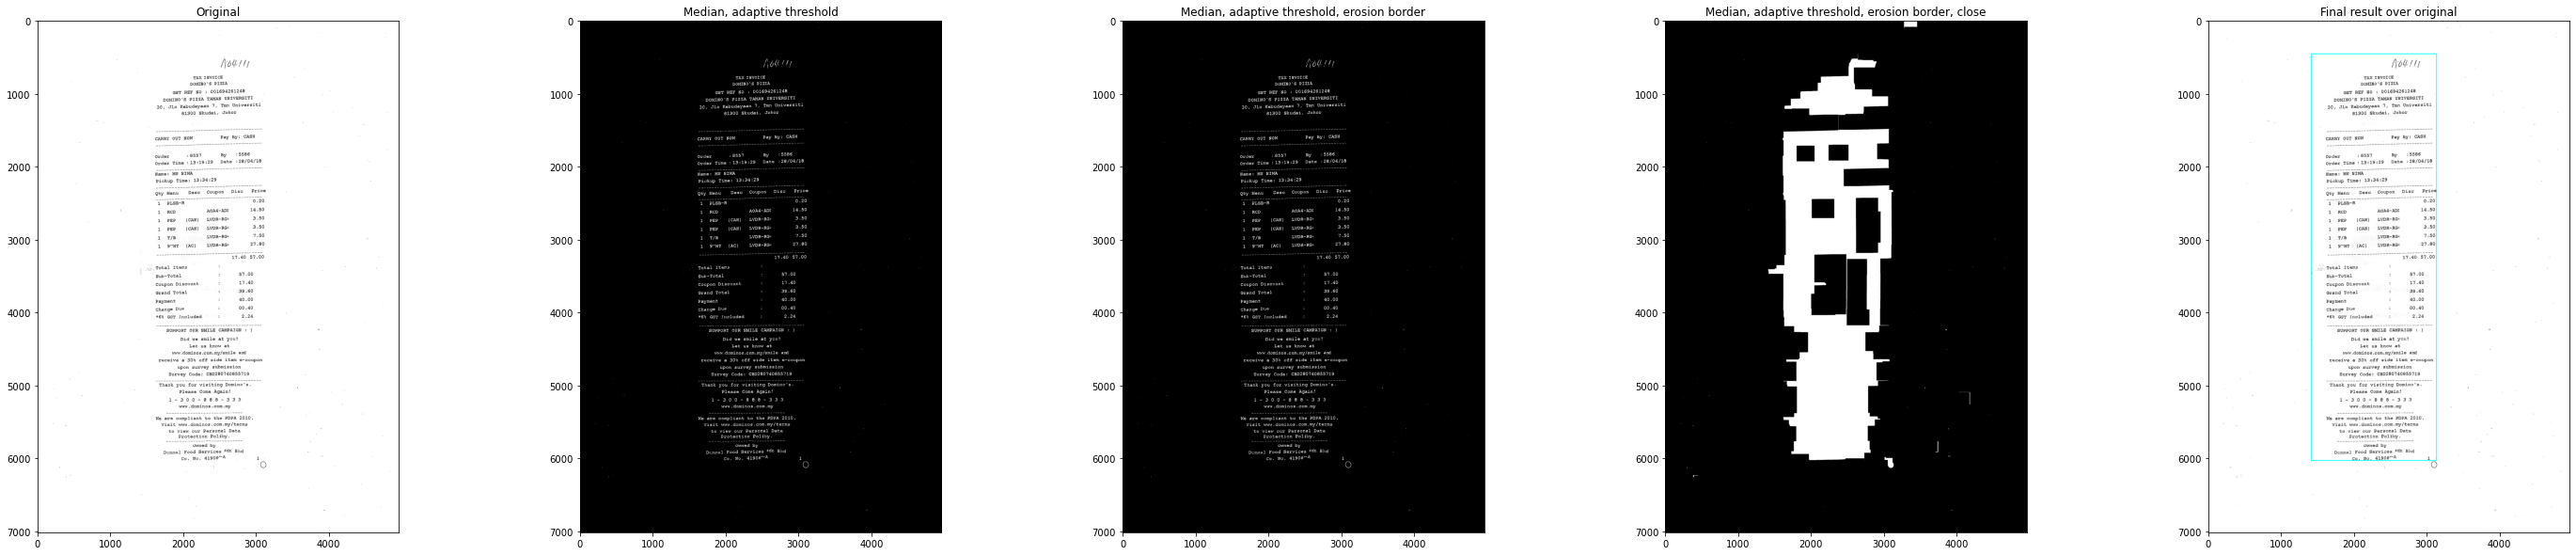

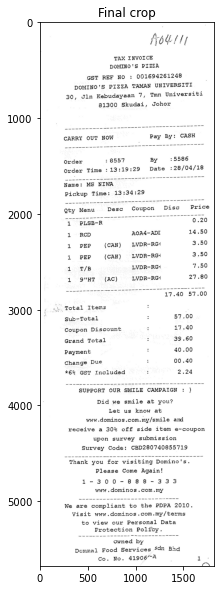

In [9]:
def implot(im, title, subplot=None, figsize=(10, 10)):
    '''
    Plot an image with given title using subplot or figsize.
    For debug purposes.
    '''
    if subplot is None:
        plt.figure(figsize=figsize)
    else:
        plt.subplot(*subplot)
    plt.title(title)
    plt.imshow(im, cmap="gray")

def extract_recibo(image, debug=False, i=0, border=50):
    '''
    Try to extract only recibo from scan with white borders.
    Uses adaptiveThreshold, morphology closing, medianblur, contour detection and 
    minimum bounding rectangle, from the opencv library.

    Visualized results in all training images, seems to work mostly fine. 
    Didn't check performance on test images.
    '''
    # Have a gray and rgb image.
    if len(image.shape) == 2:
        gray = image.copy()
        rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    else:
        rgb = image.copy()
        gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    
    # Adaptive threshold and median blur to remove small noises and have a binary image.
    t_image = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2).astype(np.int32)
    max_v = t_image.max()
    t_image = ((t_image*-1) + max_v).astype(np.uint8)
    t_image = cv2.medianBlur(t_image, 5)
    
    # Calculate border with morphology, to avoid black scan border artifacts.
    b_image = t_image - cv2.erode(t_image, np.ones((11, 11),np.uint8))  # border image

    # Close border image with a big kernel
    c_image = cv2.morphologyEx(b_image, cv2.MORPH_CLOSE, np.ones((200, 200),np.uint8))  # close borders
    
    # Find i contour of closed image
    contours, _ = cv2.findContours(c_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour = sorted(contours, key=cv2.contourArea, reverse=True)[i]

    # Get minimum bounding rect of contour
    rect = cv2.boundingRect(contour)
    
    # Debug drawings and plots to visualize processing
    if debug:
        display = rgb.copy()
        cv2.rectangle(display, (int(rect[0]), int(rect[1])), (int(rect[0]+rect[2]), int(rect[1]+rect[3])), (0, 255, 255), 10)
        
        # Display intermediate results
        plt.figure(figsize=(50, 10))
        implot(gray, "Original", (1, 5, 1))
        implot(t_image, "Median, adaptive threshold", (1, 5, 2))
        implot(b_image, "Median, adaptive threshold, erosion border", (1, 5, 3))
        implot(c_image, "Median, adaptive threshold, erosion border, close", (1, 5, 4))
        implot(display, "Final result over original", (1, 5, 5))

    # Add border space
    x, y, w, h = rect
    x -= border
    y -= border
    w += border*2
    h += border*2
    
    # Define topleft and bottom right, check for out of bounds
    tl = [y, x]
    br = [y + h, x + w]
    if tl[0] < 0: tl[0] = 0
    if tl[1] < 0: tl[1] = 0
    if br[0] >= gray.shape[0]: br[0] = gray.shape[0] - 1
    if br[1] >= gray.shape[1]: br[1] = gray.shape[1] - 1
    
    # Check ratios for incorrect boxes
    area_ratio = h*w/(gray.shape[0]*gray.shape[1])
    w_h_ratio = min(w, h)/max(w, h)
    
    if debug: print(f"Area Ratio: {area_ratio}\nWidth Height Ratio: {w_h_ratio}")
    
    # Check edge cases, last resort return original image.
    if w_h_ratio < 0.2:  # If h is very different from w, recursively take next largest contour
        return extract_recibo(image, debug=debug, i=i+1)
    elif area_ratio < 0.03:  # If crop is too excessive (probably took a very small part), return original image.
        
        return rgb
    else:
        # Return cropped RGB image.
        # print(tl[1])
        # print(br[1])
        if (int(br[0]) > 1.5*tl[0]):
          return rgb[tl[0]:int(br[0]), tl[1]:br[1]]
        else:  
          return rgb[tl[0]:int(br[0]), tl[1]:br[1]]

plt.show()
train_sample = cv2.imread('train/X51006414712.jpg')
implot(extract_recibo(train_sample, debug=True), title="Final crop")
plt.show()


In [10]:
# MODES = ["train", "test"]
MODES = ["output/train", "output/val", "test"]

class OCR_DATA(Dataset):
    '''
    Abstração do MSCOCO com 5 captions por imagem. 
    '''
    def __init__(self, mode, seq_len, TOKENIZER, N_augment=1, width=300, height=400, image_transform=Compose([transforms.ToTensor(), Lambda(lambda img: img * 2.0 - 1.0)])):
      '''
      mode: um de "train", test".
      seq_len: tamanho máximo de sequência. 64 padrão para alinhar com feature 8x8 da efficientnet.
      transform: transformadas para serem aplicadas somente na imagem.
      '''
      assert mode in MODES
      self.mode = mode
      self.seq_len = seq_len
      self.N_augment = N_augment

      self.image_transform = image_transform
      self.TOKENIZER = TOKENIZER

      self.reshape_trans = transforms.Compose([transforms.ToPILImage(), transforms.Resize((height, width))])  
      
      txt_files = glob.glob(f"{mode}/*.txt")
      self.targets = list()
      self.images = list()
      for txt_file in txt_files:
        self.images.append(txt_file[:-4]+'.jpg')
        with open(txt_file, 'r') as target_file:
          self.targets.append(json.load(target_file))

      if (self.mode == "output/train" and self.N_augment>1):
        new_images = list()
        new_targets = list()
        for i in range(len(self.images)):
            new_images.extend(self.N_augment*[self.images[i]])
            new_targets.extend(self.N_augment*[self.targets[i]])
        self.images = new_images
        self.targets = new_targets   

      self.len = len(self.targets)  


    def __len__(self):
      return self.len

    def __getitem__(self, i):
        '''
        Imagens são extraídas do H5PY, convertidas para o formato [H, W, C], float32.
        Transformadas padrão são normalização para efficientnet com advprop e totensor.
        Frase original também é retornada para cálculo do bleu.
        '''
        
        caption = self.targets[i]

        caption_company = caption["company"]
        
        cap_key = caption.get("address")
        if cap_key:
          caption_address = caption["address"]
        else:
          caption_address = " "
        
        caption = caption_company + " [NL] " + caption_address


        target = self.TOKENIZER.encode(caption,
                                        padding='max_length',
                                        truncation=True,
                                        max_length=self.seq_len,
                                        return_tensors='pt')[0]                          

        im_bgr = cv2.imread(self.images[i])
        im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)

        im_rgb = extract_recibo(im_rgb, debug=False)
        image = self.reshape_trans(im_rgb)
        
        if self.image_transform is not None:
          image = self.image_transform(image).detach().float()

        return image, caption, target

    def get_dataloader(self, batch_size, shuffle, num_workers=4):
        return DataLoader(self, batch_size=batch_size, shuffle=shuffle, pin_memory=True, num_workers=num_workers)

In [11]:
N_augmentation = 10

train_transforms = Compose(
    [transforms.ColorJitter(0.15,0.1,0.2,0.1),
     transforms.RandomRotation(10),
     transforms.ToTensor(),
     Lambda(lambda img: 2.0*(img - 1.0))])

test_transforms = Compose(
    [transforms.ToTensor(),
     Lambda(lambda img: 2.0*(img - 1.0))])

datasets = {"output/train": OCR_DATA("output/train", seq_len=hparams['seq_len'], TOKENIZER=TOKENIZER, N_augment=N_augmentation, image_transform=train_transforms),
            "output/val": OCR_DATA("output/val", seq_len=hparams['seq_len'], TOKENIZER=TOKENIZER, image_transform=test_transforms),
            "test": OCR_DATA("test", seq_len=hparams['seq_len'], TOKENIZER=TOKENIZER, image_transform=test_transforms)}

## Dados sobre uma amostra do dataset

max image tensor(-0.0627)
min image tensor(-2.)
Image shape: torch.Size([3, 400, 300])
Image .transpose(1, 2, 0) shape: (400, 300, 3)
company: DOMINO'S PIZZA [NL] DOMINO'S PIZZA TAMAN UNIVERSITI 30, JLN KEBUDAYAAN 7, TMN UNIVERSITI 81300 SKUDAI, JOHOR
target: tensor([ 6054, 17684,   667,    31,   134,   276, 20091, 19873,   784, 18207,
          908,  6054, 17684,   667,    31,   134,   276, 20091, 19873,     3,
         3221,  9312,     3, 14284, 26794,  3177,   196, 11558,   446,   434,
          567,     3,  9914,  8855, 12860,   188,  5033,  7973,     3,  2305,
          567,     3, 14284, 26794,  3177,   196,     3,  4959,  5426,     3,
        10047, 10161,  9822,     6,   446,  9195,  2990,     1,     0,     0,
            0,     0,     0,     0])


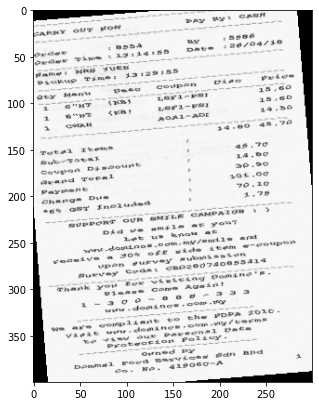

In [12]:
image = datasets["output/train"][2][0]
print('max image', image.max())
print('min image', image.min())
print('Image shape:', image.shape)
print('Image .transpose(1, 2, 0) shape:', image.cpu().numpy().transpose(1, 2, 0).shape)


plt.figure(figsize=(5, 10))
plt.imshow(((image.cpu().numpy().transpose(1, 2, 0)/2+1)))

company = datasets["output/train"][2][1]
print('company:', company)

target = datasets["output/train"][2][2]
print('target:', target)

## Representação das mesma imagem que foram augmentadas 5x

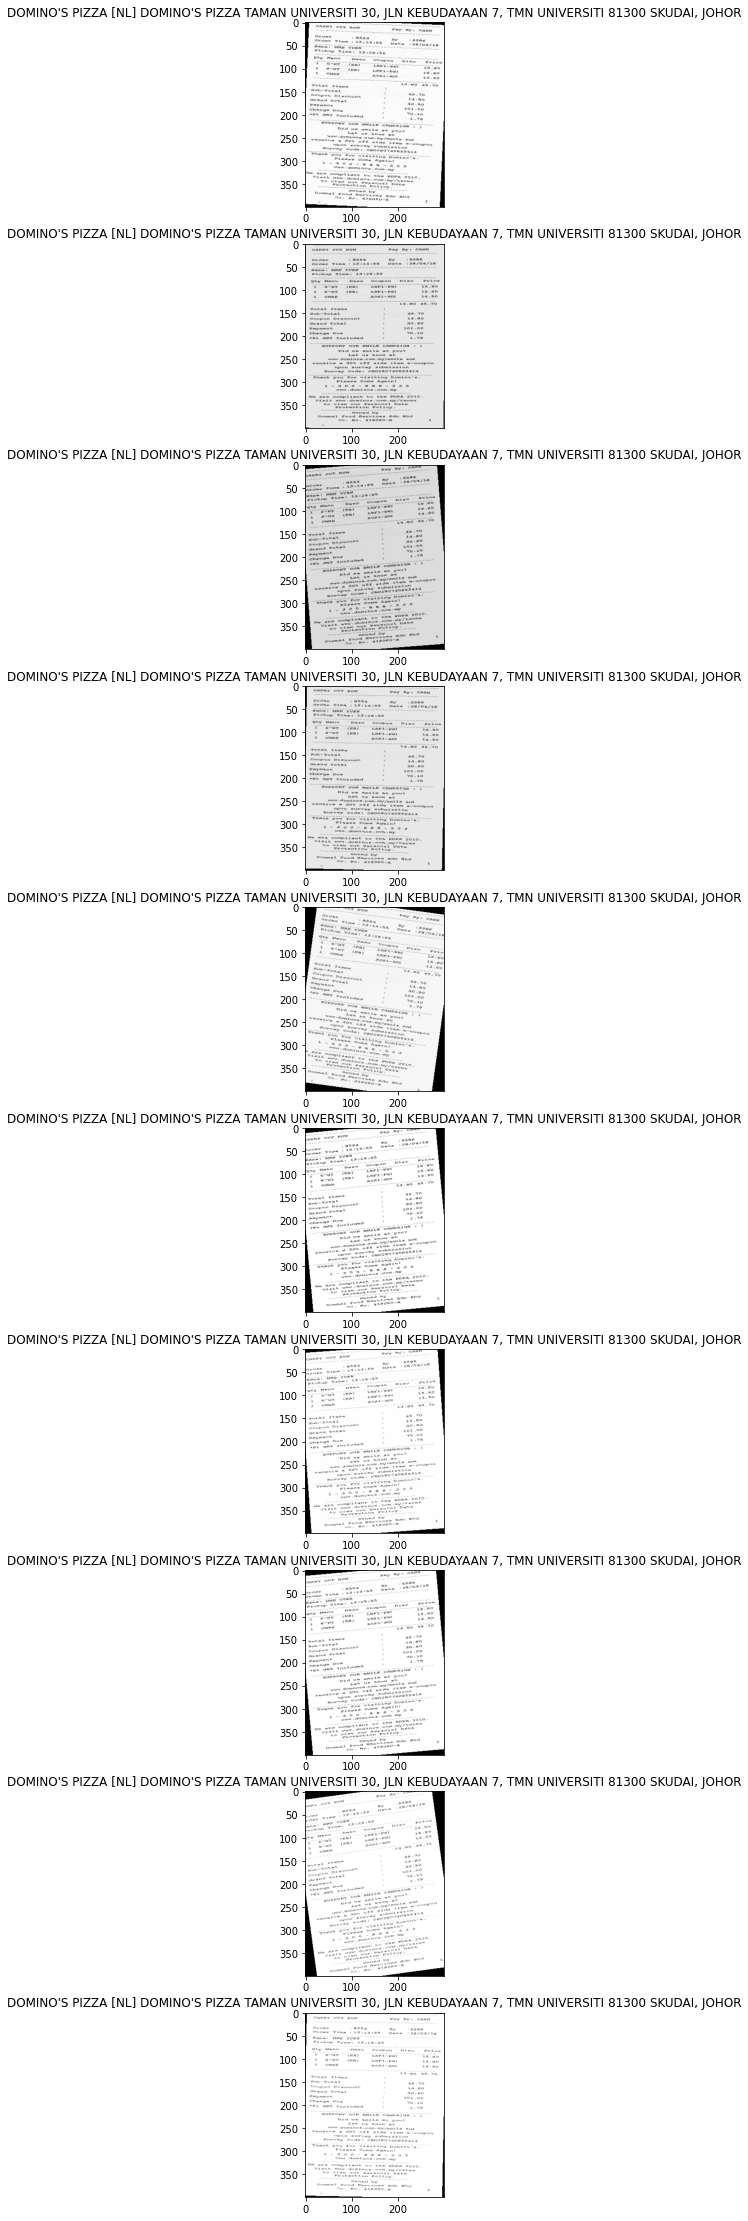

In [13]:
if N_augmentation>1:
  fig, axs = plt.subplots(N_augmentation, 1, figsize=(10, 40))
  for i in range(N_augmentation):
    image = datasets["output/train"][i][0]
    company = datasets["output/train"][i][1]
    axs[i].set_title(company)
    axs[i].imshow(((image.cpu().numpy().transpose(1, 2, 0)/2+1)))
  plt.show()

In [14]:
dataset_lens = {mode: len(datasets[mode]) for mode in MODES}

In [15]:
print(f"Lens: {dataset_lens}")

Lens: {'output/train': 3190, 'output/val': 107, 'test': 200}


798
Train batch
torch.Size([3, 400, 300])
Company: ADVANCO COMPANY [NL] NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR ; target: tensor([   71, 13529, 23190,   667, 23666,   188, 12056,   784, 18207,   908,
         5693,   209,   184,  6355,     3, 13853, 12303,   549, 19775,  4507,
          309, 22590,  4148, 10440,   549, 19775,  4507,     3, 27472,     6,
          549, 19775,  4507,  4800,   683,  1265,     6, 12210,  5426,     3,
        18519, 23634,   301, 28468,  5905,     1,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


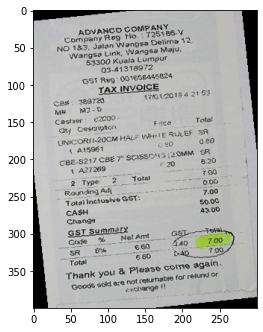

torch.Size([3, 400, 300])
Company: AMANO MALAYSIA SDN BHD [NL] 12 JALAN PENGACARA U1/48 TEMASYA INDUSTRIAL PARK 40150 SHAH ALAM SELANGOR ; target: tensor([    3, 21250,  7400,  4800, 29002, 29689,   180, 12145,   272, 11083,
          784, 18207,   908,   586,     3, 13853, 12303,   276, 23182, 22029,
         4763,   412, 12989,  3707,     3, 20050,  3291, 17419,  3388,  7874,
        13733, 15397,   276, 22216,  1283, 12278,     3, 19964,   566,  8761,
         4815,     3, 23143, 19775,  2990,     1,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


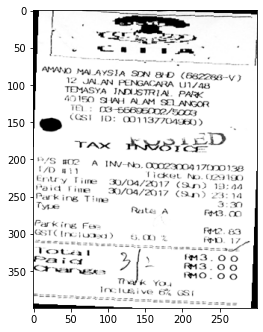

torch.Size([3, 400, 300])
Company: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR. ; target: tensor([    3, 25826,  5596, 26077,   272, 17253, 25858,   134,    41,   439,
          434,    61,   180, 12145,   272, 11083,   784, 18207,   908,     3,
        19912,  6180,     3, 13853, 12303, 11012, 26810,  5905,  1902, 14785,
            6,  1283,  5426,     3, 19964,   566,  8761,  4815,     6,     3,
        23143, 19775,  2990,     5,     1,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


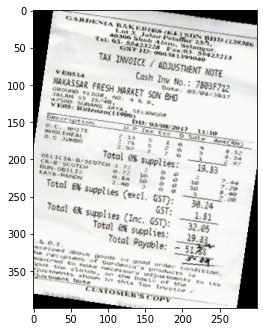

torch.Size([3, 400, 300])
Company: SUNFISH [NL] 22 LRG PERUSAHAAN 4 KIMPAL INDS.PARK B.CAVES ; target: tensor([    3,  4138, 12619, 20619,   784, 18207,   908,  1630,   301, 12912,
            3,  8742, 17663,  5478,  5033,   314,   480, 25657,  4090,  3388,
         3592,     5,   345, 22216,   272,     5,   254, 18111,   134,     1,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


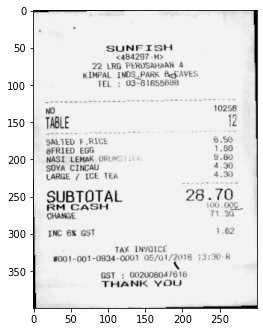

----------------------------------------
Test batch
Company: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR ; target: tensor([   71, 13529, 23190,   667, 23666,   188, 12056,   784, 18207,   908,
         5693,   209,   184,  6355,     3, 13853, 12303,   549, 19775,  4507,
          309, 22590,  4148, 10440,   549, 19775,  4507,     3, 27472,     6,
          549, 19775,  4507,  4800,   683,  1265,     6, 12210,  5426,     3,
        18519, 23634,   301, 28468,  5905,     1,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


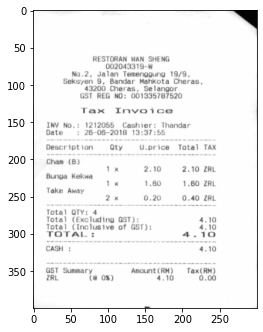

Company: SANYU STATIONERY SHOP [NL] NO. 31G&33G, JALAN SETIA INDAH X ,U13/X 40170 SETIA ALAM ; target: tensor([    3, 21250,  7400,  4800, 29002, 29689,   180, 12145,   272, 11083,
          784, 18207,   908,   586,     3, 13853, 12303,   276, 23182, 22029,
         4763,   412, 12989,  3707,     3, 20050,  3291, 17419,  3388,  7874,
        13733, 15397,   276, 22216,  1283, 12278,     3, 19964,   566,  8761,
         4815,     3, 23143, 19775,  2990,     1,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


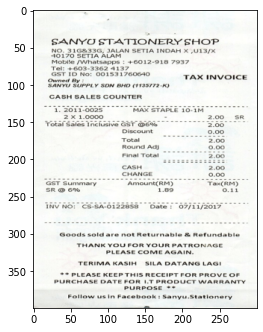

Company: GERBANG ALAF RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39,47400 PETALING JAYA SELANGOR ; target: tensor([    3, 25826,  5596, 26077,   272, 17253, 25858,   134,    41,   439,
          434,    61,   180, 12145,   272, 11083,   784, 18207,   908,     3,
        19912,  6180,     3, 13853, 12303, 11012, 26810,  5905,  1902, 14785,
            6,  1283,  5426,     3, 19964,   566,  8761,  4815,     6,     3,
        23143, 19775,  2990,     5,     1,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


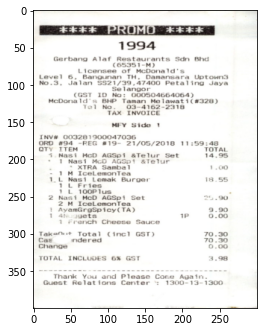

Company: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR ; target: tensor([    3,  4138, 12619, 20619,   784, 18207,   908,  1630,   301, 12912,
            3,  8742, 17663,  5478,  5033,   314,   480, 25657,  4090,  3388,
         3592,     5,   345, 22216,   272,     5,   254, 18111,   134,     1,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


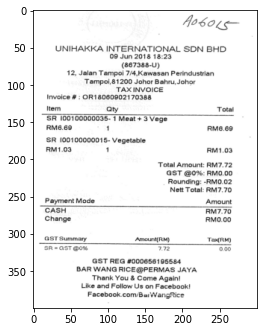

In [16]:
display_dataloaders = {mode: datasets[mode].get_dataloader(batch_size=4, shuffle=True) for mode in MODES}

print(len(display_dataloaders["output/train"]))

# Test-load batchs 
train_batch, test_batch = next(iter(display_dataloaders["output/train"])), next(iter(display_dataloaders["test"]))

print("Train batch")
for image, company, target in zip(train_batch[0], train_batch[1], train_batch[2]):
  print(image.shape)
  plt.figure(figsize=(4, 10))
  print(f"Company: {company}", f"; target: {target}")
  plt.imshow(((image.squeeze(0).cpu().numpy().transpose(1, 2, 0)/2+1)))
  plt.show()  
print('----------------------------------------')

print("Test batch")
for image, company, target in zip(test_batch[0], test_batch[1], train_batch[2]):
  plt.figure(figsize=(4, 10))
  print(f"Company: {company}", f"; target: {target}")
  plt.imshow(((image.squeeze(0).cpu().numpy().transpose(1, 2, 0)/2+1)))
  plt.show()

## Métricas

Usar as funções abaixo para calcular as métricas (exact match e F1):

In [17]:
import collections

def normalize_answer(s):
    """Lower text and remove extra whitespace."""

    def white_space_fix(text):
        return ' '.join(text.split())

    def lower(text):
        return text.lower()

    return white_space_fix(lower(s))

def get_tokens(s):
    if not s: return []
    return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

# Definir a classe do modelo usado EfficientT5

In [18]:
"""
Code borrowed with thanks from:
https://github.com/ndrplz/ConvLSTM_pytorch
https://github.com/shreyaspadhy/UNet-Zoo/blob/master/CLSTM.py
https://gist.github.com/halochou/acbd669af86ecb8f988325084ba7a749
"""

import torch.nn as nn
import torch


class ConvGRUCell(nn.Module):
    """
    Basic CGRU cell.
    """

    def __init__(self, in_channels, hidden_channels, kernel_size, bias):

        super(ConvGRUCell, self).__init__()

        self.input_dim  = in_channels
        self.hidden_dim = hidden_channels

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        self.update_gate = nn.Conv2d(in_channels=self.input_dim+self.hidden_dim, out_channels=self.hidden_dim,
                                     kernel_size=self.kernel_size, padding=self.padding,
                                     bias=self.bias)
        self.reset_gate = nn.Conv2d(in_channels=self.input_dim+self.hidden_dim, out_channels=self.hidden_dim,
                                    kernel_size=self.kernel_size, padding=self.padding,
                                    bias=self.bias)

        self.out_gate = nn.Conv2d(in_channels=self.input_dim+self.hidden_dim, out_channels=self.hidden_dim,
                                  kernel_size=self.kernel_size, padding=self.padding,
                                  bias=self.bias)

    def forward(self, input_tensor, cur_state):

        h_cur = cur_state
        # data size is [batch, channel, height, width]
        x_in = torch.cat([input_tensor, h_cur], dim=1)
        update = torch.sigmoid(self.update_gate(x_in))
        reset = torch.sigmoid(self.reset_gate(x_in))
        x_out = torch.tanh(self.out_gate(torch.cat([input_tensor, h_cur * reset], dim=1)))
        h_new = h_cur * (1 - update) + x_out * update

        return h_new

    def init_hidden(self, b, h, w):
        return torch.zeros(b, self.hidden_dim, h, w).cuda()


class ConvGRU(nn.Module):

    def __init__(self, in_channels, hidden_channels, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvGRU, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_channels = self._extend_for_multilayer(hidden_channels, num_layers)
        if not len(kernel_size) == len(hidden_channels) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim  = in_channels
        self.hidden_dim = hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]

            cell_list.append(ConvGRUCell(in_channels=cur_input_dim,
                                          hidden_channels=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        # Implement stateful ConvGRU
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            b, _, _, h, w = input_tensor.shape
            hidden_state = self._init_hidden(b, h, w)

        layer_output_list = []
        last_state_list   = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):

                h = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=h)
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append(h)

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, b, h, w):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(b, h, w))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                    (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param


class ConvBGRU(nn.Module):
    # Constructor
    def __init__(self, in_channels, hidden_channels,
                 kernel_size, num_layers, bias=True, batch_first=False):

        super(ConvBGRU, self).__init__()
        self.forward_net = ConvGRU(in_channels, hidden_channels//2, kernel_size,
                                    num_layers, batch_first=batch_first, bias=bias)
        self.reverse_net = ConvGRU(in_channels, hidden_channels//2, kernel_size,
                                    num_layers, batch_first=batch_first, bias=bias)

    def forward(self, xforward, xreverse):
        """
        xforward, xreverse = B T C H W tensors.
        """

        y_out_fwd, _ = self.forward_net(xforward)
        y_out_rev, _ = self.reverse_net(xreverse)

        y_out_fwd = y_out_fwd[-1] # outputs of last CGRU layer = B, T, C, H, W
        y_out_rev = y_out_rev[-1] # outputs of last CGRU layer = B, T, C, H, W

        reversed_idx = list(reversed(range(y_out_rev.shape[1])))
        y_out_rev = y_out_rev[:, reversed_idx, ...] # reverse temporal outputs.
        ycat = torch.cat((y_out_fwd, y_out_rev), dim=2)

        return ycat


In [19]:
"""
Code borrowed with thanks from:
Shreyas Padhy, and Andrea Palazzi
https://github.com/ndrplz/ConvLSTM_pytorch
https://github.com/shreyaspadhy/UNet-Zoo/blob/master/CLSTM.py
"""

import torch.nn as nn
import torch


class ConvLSTMCell(nn.Module):
    """
    Basic CLSTM cell.
    """

    def __init__(self, in_channels, hidden_channels, kernel_size, bias):

        super(ConvLSTMCell, self).__init__()

        self.input_dim  = in_channels
        self.hidden_dim = hidden_channels

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        
        h_cur, c_cur = cur_state
        
        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis
        
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1) 
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        
        return h_next, c_next

    def init_hidden(self, b, h, w):
        return (torch.zeros(b, self.hidden_dim, h, w).cuda(),
                torch.zeros(b, self.hidden_dim, h, w).cuda())


class ConvLSTM(nn.Module):

    def __init__(self, in_channels, hidden_channels, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_channels = self._extend_for_multilayer(hidden_channels, num_layers)
        if not len(kernel_size) == len(hidden_channels) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim  = in_channels
        self.hidden_dim = hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]

            cell_list.append(ConvLSTMCell(in_channels=cur_input_dim,
                                          hidden_channels=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            b, _, _, h, w = input_tensor.shape
            hidden_state = self._init_hidden(b, h, w)

        layer_output_list = []
        last_state_list   = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):

                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, b, h, w):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(b, h, w))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                    (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param


class ConvBLSTM(nn.Module):
    # Constructor
    def __init__(self, in_channels, hidden_channels,
                 kernel_size, num_layers, bias=True, batch_first=False):

        super(ConvBLSTM, self).__init__()
        self.forward_net = ConvLSTM(in_channels, hidden_channels//2, kernel_size,
                                    num_layers, batch_first=batch_first, bias=bias)
        self.reverse_net = ConvLSTM(in_channels, hidden_channels//2, kernel_size,
                                    num_layers, batch_first=batch_first, bias=bias)
        
    def forward(self, xforward, xreverse):
        """
        xforward, xreverse = B T C H W tensors.
        """

        y_out_fwd, _ = self.forward_net(xforward)
        y_out_rev, _ = self.reverse_net(xreverse)

        y_out_fwd = y_out_fwd[-1] # outputs of last CLSTM layer = B, T, C, H, W
        y_out_rev = y_out_rev[-1] # outputs of last CLSTM layer = B, T, C, H, W

        reversed_idx = list(reversed(range(y_out_rev.shape[1])))
        y_out_rev = y_out_rev[:, reversed_idx, ...] # reverse temporal outputs.
        ycat = torch.cat((y_out_fwd, y_out_rev), dim=2)
        
        return ycat

In [20]:
def set_bn_eval(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm2d') != -1:
        print('freezing ', m)
        m.eval()

In [21]:
class EfficientT5(pl.LightningModule):

    def __init__(self, params):
        super(EfficientT5, self).__init__()

        self.params = params
        
        override_params = {'dropout_rate':params['dropout_rate'],'drop_connect_rate':params['drop_connect_rate']}

        # Features da efficient net atuarão como as features do encoder do T5
        self.encoder = EfficientNet.from_pretrained(params['enet'], advprop=True, **override_params)
        # freeze BN
        self.encoder = self.encoder.apply(set_bn_eval)
        
        
        self.decoder = T5ForConditionalGeneration.from_pretrained(params['t5'])
        self.bridge = ConvGRU(in_channels=int(112/2), hidden_channels=self.decoder.config.d_model, kernel_size=(3, 3), num_layers=1, batch_first=True)

        self.tokenizer = TOKENIZER

    def _get_efn_embeddings(self, images):

        # Shape (N, 112, 16, 16)
        # features = self.encoder.extract_features(images)
        features = self.encoder.extract_endpoints(images)["reduction_4"]
        # print('features shape', features.shape)

        features = features.unsqueeze(1)

        
        # features = features.reshape(features.shape[0], 1, 112, 25, 19) #best

        features = features.reshape(features.shape[0], 2, int(112/2), 25, 19)

        # Shape: (N, 512, -, -)
        features, last_state_list = self.bridge(features)
        
        features = features[0]

        # Shape: (N, -1, 512) -> Pra ficar do shape de entrada do decoder que é (N, seq_len, d_model)
        efn_embeddings = features \
            .permute(0, 1, 3, 4, 2) \
            .reshape(features.shape[0], -1, self.decoder.config.d_model)

        return efn_embeddings

    
    def _generate_tokens(self, efn_embeddings):
        '''
        Token generation
        '''
        max_length = self.params['seq_len']

        # Add start of sequence token
        decoded_ids = torch.full((efn_embeddings.shape[0], 1),
                                 self.decoder.config.decoder_start_token_id,
                                 dtype=torch.long).to(efn_embeddings.device)
        
        encoder_hidden_states = self.decoder.get_encoder()(inputs_embeds=efn_embeddings)

        for step in range(max_length-1):
            logits = self.decoder(decoder_input_ids=decoded_ids,
                                  encoder_outputs=encoder_hidden_states)[0]
            next_token_logits = logits[:, -1, :]

            # decoding
            next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
            
            # Check if output is end of senquence for all batches
            if torch.eq(next_token_id[:, -1], self.tokenizer.eos_token_id).all():
                break

            # Concatenate past ids with new id, keeping batch dimension
            decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)

        return decoded_ids

    def forward(self, batch): # TODO pro futuro: colocar os dados necessários individualmente e não o batch inteiro
        # Aqui os labels são strings e os tokens são os labels a serem inseridos no decoder
        # print(len(batch))
        images, label, token = batch

        # Output do efn atua como embedding do encoder
        efn_embeddings = self._get_efn_embeddings(images)
        # print('efn_embeddings', efn_embeddings.shape)

        if self.training:
            outputs = self.decoder(inputs_embeds=efn_embeddings,
                                   decoder_input_ids=None, 
                                   labels=token,
                                   return_dict=True)
            return outputs.loss
        else:
            return self._generate_tokens(efn_embeddings)

    def training_step(self, batch, batch_idx): 
        loss = self(batch)
        self.log('loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_tokens = self(batch)
        # Tokens -> String
        decoded_pred = [self.tokenizer.decode(tokens) for tokens in pred_tokens]
        
        images, label, token = batch

        efn_embeddings = self._get_efn_embeddings(images)

        outputs = self.decoder(inputs_embeds=efn_embeddings,
                                decoder_input_ids=None, 
                                labels=token,
                                return_dict=True)

        val_loss = outputs.loss.detach().cpu().numpy()

        return {"val_loss": val_loss, "pred": decoded_pred, "target": batch[1]}

    def test_step(self, batch, batch_idx):
        pred_tokens = self(batch)
        # Tokens -> String
        decoded_pred = [self.tokenizer.decode(tokens) for tokens in pred_tokens]
        
        images, label, token = batch

        efn_embeddings = self._get_efn_embeddings(images)

        outputs = self.decoder(inputs_embeds=efn_embeddings,
                                decoder_input_ids=None, 
                                labels=token,
                                return_dict=True)

        test_loss = outputs.loss.detach().cpu().numpy()

        return {"test_loss": test_loss, "pred": decoded_pred, "target": batch[1]}


    def validation_epoch_end(self, outputs):
        # Flatten dos targets e preds para arrays
        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        # n = random.choice(range(len(trues)))
        n_samples = random.sample(range(len(trues)), 1)
        for n in n_samples:
            print(f"\nSample Target: {trues[n]}\nPrediction: {preds[n]}\n")
        
        f1 = []
        exact = []
        for true, pred in zip(trues, preds):
            f1.append(compute_f1(a_gold=true, a_pred=pred))
            exact.append(compute_exact(a_gold=true, a_pred=pred))
        f1 = np.mean(f1)
        exact = np.mean(exact)

        bleu = sacrebleu.corpus_bleu(preds, [trues])

        val_loss = sum([x['val_loss'] for x in outputs])/len(outputs)

        self.log("val_loss", val_loss, prog_bar=True)

        self.log("val_bleu_score", bleu.score, prog_bar=True)
        self.log("val_bleu_1", bleu.precisions[0], prog_bar=True)
        self.log("val_bleu_4", bleu.precisions[3], prog_bar=True)
        self.log("val_f1", f1, prog_bar=True)
        self.log("val_exact", exact, prog_bar=True)

        return {'val_f1': f1, 'val_loss': val_loss}

    def test_epoch_end(self, outputs):
        # Flatten dos targets e preds para arrays
        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        n = random.choice(range(len(trues)))
        print(f"\nSample Target: {trues[n]}\nPrediction: {preds[n]}\n")

        f1 = []
        exact = []
        for true, pred in zip(trues, preds):
            f1.append(compute_f1(a_gold=true, a_pred=pred))
            exact.append(compute_exact(a_gold=true, a_pred=pred))
        f1 = np.mean(f1)
        exact = np.mean(exact)

        bleu = sacrebleu.corpus_bleu(preds, [trues])

        test_loss = sum([x['test_loss'] for x in outputs])/len(outputs)
        
        self.log("test_loss", test_loss, prog_bar=True)
        self.log("test_bleu_score", bleu.score, prog_bar=True)
        self.log("test_bleu_1", bleu.precisions[0], prog_bar=True)
        self.log("test_bleu_4", bleu.precisions[3], prog_bar=True)
        self.log("test_f1", f1, prog_bar=True)
        self.log("test_exact", exact, prog_bar=True)
    
    def configure_optimizers(self):
        optimizer = adafactor.Adafactor(self.parameters(), weight_decay=0.001, eps=(1e-30, self.params['lr'])) # weight_decay=0.01
#         optimizer = adafactor.Adafactor(self.parameters(), weight_decay=0.01, scale_parameter=False, eps=(1e-30, self.params['lr']),
#                                         lr=self.params['lr'], relative_step=False)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor':'val_loss'}
    
    def train_dataloader(self):
        return datasets["output/train"].get_dataloader(batch_size=self.params['bs'], shuffle=True)
    def val_dataloader(self):
        return datasets["output/val"].get_dataloader(batch_size=self.params['bs'], shuffle=False)    
    def test_dataloader(self):
        return datasets["test"].get_dataloader(batch_size=self.params['bs'], shuffle=False)

# Definir os hiper-parametros do modelo
## Diversos hiper-parametros foram testados, mas os melhores valores foram obtidos com os parametros abaixo 


**Os parâmetros de *dropout_rate* e *drop_connect_rate* da efficient-net são bastante interessantes podendo dar um maior domínio sobre a efficiente-net**

In [22]:
neptune_logger = NeptuneLogger(
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiYzJiZGU4NWMtZDI0NS00ZjIxLWIwZmMtZDI1ZTJjMTg3MjE4In0=",
    project_name="orllem/ocr-recibos-fine-tuning-augment-newvalidation",
    params=hparams)

https://ui.neptune.ai/orllem/ocr-recibos-fine-tuning-augment-newvalidation/e/OC-11


NeptuneLogger will work in online mode
2021-01-09 17:40:11 | INFO | lightning | NeptuneLogger will work in online mode


In [29]:

# Initialize Lightning Module with parameters defined above.
# model = EfficientT5(hparams)
pre_model = "aula12_checkpoints/cloud_reduced_part_final_netupne_adafactor_gpu_model-epoch=7-step=10679.ckpt"
model = EfficientT5(hparams).load_from_checkpoint(pre_model, params=hparams)
print(model)

# Configure callbacks
if hparams["debug"]:
  checkpoint_callback = None
  logger = None
  early_stop_callback = None
else:
  checkpoint_path = 'aula8_checkpoints/epoch=10.ckpt'
  checkpoint_dir = os.path.dirname(os.path.abspath(checkpoint_path))
  print(f'Files in {checkpoint_dir}: {os.listdir(checkpoint_dir)}')
  print(f'Saving checkpoints to {checkpoint_dir}')
  checkpoint_callback = pl.callbacks.ModelCheckpoint(prefix=hparams["version"],
                                                      filepath=checkpoint_dir,
                                                      save_top_k=1, 
                                                      monitor="val_f1", mode="max")
  early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_f1', patience=hparams["patience"], mode='max')

trainer = pl.Trainer(gpus=1,
                     fast_dev_run=hparams["debug"],
                     accumulate_grad_batches=hparams["accum"],
                     # logger=neptune_logger,
                     checkpoint_callback=checkpoint_callback, 
                     callbacks=[early_stop_callback],
                     max_epochs=hparams["max_epochs"])

Loaded pretrained weights for efficientnet-b0
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(16, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(96, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(96, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(144, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(144, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_s

GPU available: True, used: True
2021-01-12 01:52:29 | INFO | lightning | GPU available: True, used: True
TPU available: None, using: 0 TPU cores
2021-01-12 01:52:29 | INFO | lightning | TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2021-01-12 01:52:29 | INFO | lightning | LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


EfficientT5(
  (encoder): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_

In [24]:
trainer.fit(model)


  | Name    | Type                       | Params
-------------------------------------------------------
0 | encoder | EfficientNet               | 5.3 M 
1 | decoder | T5ForConditionalGeneration | 60.5 M
2 | bridge  | ConvGRU                    | 7.9 M 
-------------------------------------------------------
73.6 M    Trainable params
0         Non-trainable params
73.6 M    Total params
2021-01-09 17:40:16 | INFO | lightning | 
  | Name    | Type                       | Params
-------------------------------------------------------
0 | encoder | EfficientNet               | 5.3 M 
1 | decoder | T5ForConditionalGeneration | 60.5 M
2 | bridge  | ConvGRU                    | 7.9 M 
-------------------------------------------------------
73.6 M    Trainable params
0         Non-trainable params
73.6 M    Total params



Sample Target: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR
Prediction:  ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇  



/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)



Sample Target: THE STORE (MALAYSIA) SDN BHD [NL] LOT 34817 JALAN BATU AMBAR TAMAN KOK LIAN 51200 KUALA LUMPUR,
Prediction: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



2021-01-09 17:46:51 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-11. Cause: Error(code=400, message='X-coordinat


Sample Target: GL HANDICRAFT & TAII ORING [NL] 19, JALAN KANCIL, OFF JALAN PUDU, 55100 KUALA LUMPUR MALAYSIA
Prediction: G. HANDICRAFT & TAII ORING [NL] 19, JALAN KANCIL, OFF JALAN PUDU, 55100 KUALA LUMPUR MALAYSIA



2021-01-09 17:53:06 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-11. Cause: Error(code=400, message='X-coordinat


Sample Target: THE STORE (MALAYSIA) SDN BHD [NL] LOT 34817 JALAN BATU AMBAR TAMAN KOK LIAN 51200 KUALA LUMPUR,
Prediction: CHECKERS HYPERMARKET SDN BHD (JALAN KLANG LAMA) [NL] LOT 2942 & 2945, JLN SERI SENTOSA 8, SERI SENTOSA, OFF JLN KLANG LAMA, 5



2021-01-09 17:59:21 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-11. Cause: Error(code=400, message='X-coordinat


Sample Target: SAM SAM TRADING CO [NL] 67,JLN MEWAH 25/63 TMN SRI MUDA, 40400 SHAH ALAM.
Prediction: SUBANG HEALTHCARE SDN BHD [NL] B-8, JALAN SS15/4D, 47500 SUBANG JAYA, SELANGOR



2021-01-09 18:05:36 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-11. Cause: Error(code=400, message='X-coordinat


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1317 TRILLIUM S6 BESI
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1214-JINJANG UTARA



2021-01-09 18:11:51 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-11. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-09 18:18:06 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-11. Cause: Error(code=400, message='X-coordinat


Sample Target: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR
Prediction: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR



2021-01-09 18:24:21 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-11. Cause: Error(code=400, message='X-coordinat


Sample Target: ADVANCO COMPANY [NL] NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR
Prediction: ADVANCO COMPANY [NL] NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR



2021-01-09 18:30:36 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-11. Cause: Error(code=400, message='X-coordinat


Sample Target: GREEN LANE PHARMACY SDN BHD [NL] 33 JLN BANGAU 1,KEPONG BARU, 52100 KEPONG,KL
Prediction: SEGI CASH & CARRY SDN BHD [NL] PT17920, SEKSYEN U9, 40150 SHAH ALAM, SELANGOR.



2021-01-09 18:36:51 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-11. Cause: Error(code=400, message='X-coordinat


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1313-SUBANG BESTARI
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1214-JINJANG UTARA



2021-01-09 18:43:06 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-11. Cause: Error(code=400, message='X-coordinat


Sample Target: SOON HUAT MACHINERY ENTERPRISE [NL] NO.53 JALAN PUTRA 1, TAMAN SRI PUTRA, 81200 JOHOR BAHRU JOHOR
Prediction: SUNNATHAMBY HOLDINGS SDN. BHD. [NL] NO.23 BATU 10, TAMAN BRINCHANG, 43200 CHERAS, SEL.



2021-01-09 18:49:27 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-11. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-09 18:55:47 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-11. Cause: Error(code=400, message='X-coordinat


Sample Target: AEON CO. (M) BHD [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR
Prediction: AEON CO. (M) BHD [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR




2021-01-09 19:01:58 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-11. Cause: Error(code=400, message='X-coordinat

1

# Resultados do melhor modelo no Teste

In [25]:
test_dl = datasets["test"].get_dataloader(batch_size=32, shuffle=False, num_workers=4)

In [23]:
best_model = "aula8_checkpoints/finetuning_adlr_augm_extract_app1_adafactor_seqred_test3-epoch=2-step=134.ckpt"
test_model = EfficientT5(hparams).load_from_checkpoint(best_model, params=hparams).cuda().eval()

Loaded pretrained weights for efficientnet-b0
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(16, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(96, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(96, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(144, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(144, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_s

In [30]:
trainer.test(test_model, test_dl)


Sample Target: KEDAI RUNCIT ZBH [NL] NO.17,JALAN PERMAS 1/7, BANDAR BARU PERMAS JAYA,81750,MASAI
Prediction: CHECKERS HYPERMARKET SDN BHD (JALAN KLANG LAMA) [NL] LOT 2942 & 2945, JLN SERI SENTOSA 8, SERI SENTOSA, OFF JLN KLANG LAMA, 5


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_bleu_1': 73.67904144568847,
 'test_bleu_4': 58.54472630173565,
 'test_bleu_score': 60.619319205554355,
 'test_exact': 0.23,
 'test_f1': 0.5877641039054186,
 'test_loss': 0.9126235161508832}
--------------------------------------------------------------------------------


[{'test_loss': 0.9126235161508832,
  'test_bleu_score': 60.619319205554355,
  'test_bleu_1': 73.67904144568847,
  'test_bleu_4': 58.54472630173565,
  'test_f1': 0.5877641039054186,
  'test_exact': 0.23}]

# Aplicação do modelo em alguns caso do Teste

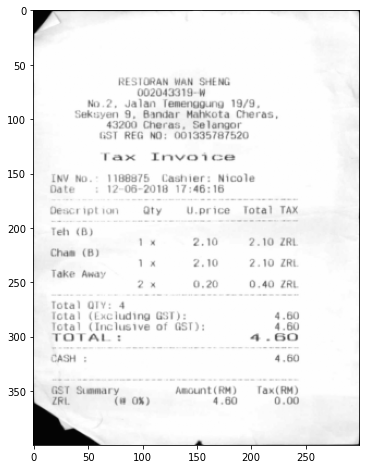

Labels: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Pred: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR



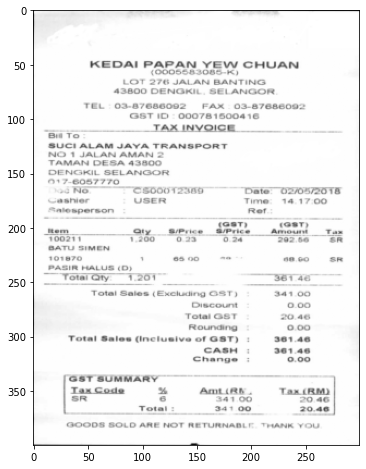

Labels: KEDAI PAPAN YEW CHUAN [NL] LOT 276 JALAN BANTING 43800 DENGKIL, SELANGOR
Pred: KEDAI PAPAN YEW CHUAN [NL] LOT 276 JALAN BANTING 43800 DENGKIL, SELANGOR.



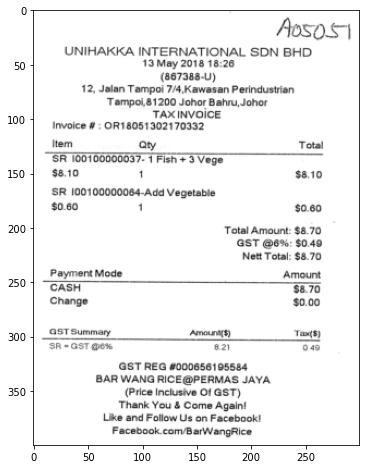

Labels: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR
Pred: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR



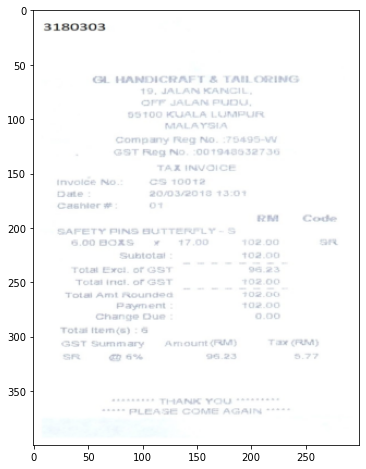

Labels: GL HANDICRAFT & TAIL ORING [NL] 19, JALAN KANCIL, OFF JALAN PUDU, 55100 KUALA LUMPUR MALAYSIA
Pred: GL HANDICRAFT & TAII ORING [NL] 19, JALAN KANCIL, OFF JALAN PUDU, 55100 KUALA LUMPUR MALAYSIA



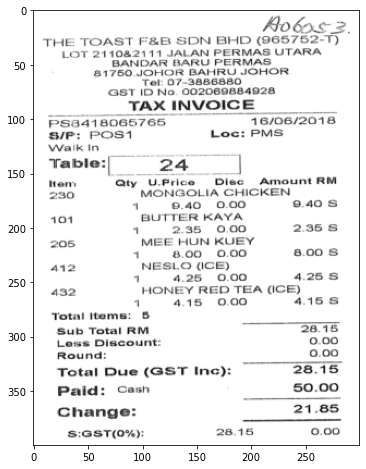

Labels: THE TOAST F&B SDN BHD [NL] LOT 2110&2111 JALAN PERMAS UTARA BANDAR BARU PERMAS 81750 JOHOR BAHRU JOHOR
Pred: THE TOAST F&B SDN BHD [NL] LOT 2110&2111 JALAN PERMAS UTARA BANDAR BARU PERMAS 81750 JOHOR BAHRU JOHOR



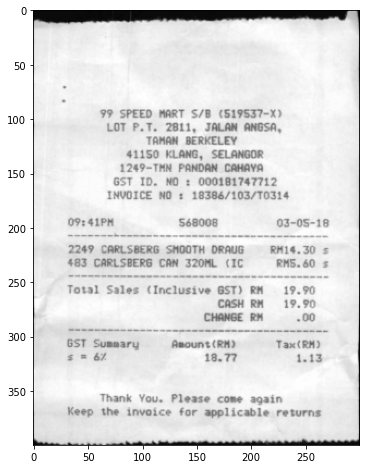

Labels: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1249-TMN PANDAN CAHAYA
Pred: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1249-TMN PANDAN CAHAYA



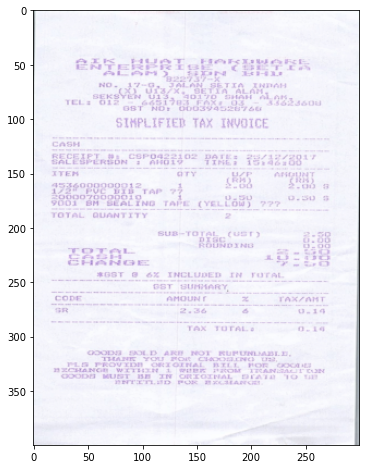

Labels: AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD [NL] NO. 17-G, JALAN SETIA INDAH (X) U13/X, SETIA ALAM, SEKSYEN U13, 40170 SHAH ALAM,
Pred: TSH POWER HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD [NL] 109, JALAN SS21/60, DAMANSARA UTAMA PETALING JAYA, SELANGOR DARUL EHSAN.



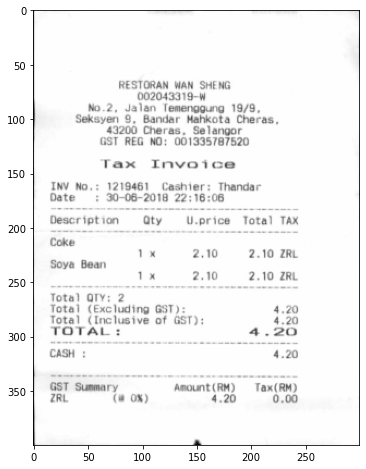

Labels: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Pred: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR



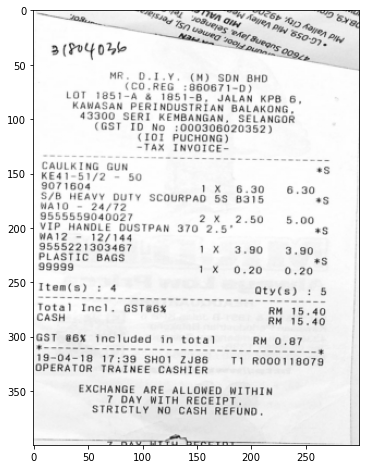

Labels: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Pred: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



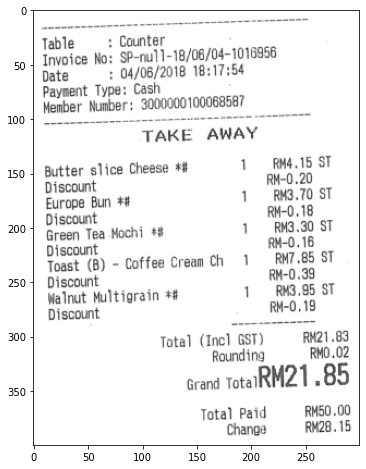

Labels: MOONLIGHT CAKE HOUSE SDN BHD [NL] NO.1, JALAN PERMAS 10/5, BANDAR BARU PERMAS JAYA 81750 JOHOR BAHRU, JOHOR.
Pred: TASTE [NL] 109, SS21/1A, DAMANSARA, 47500



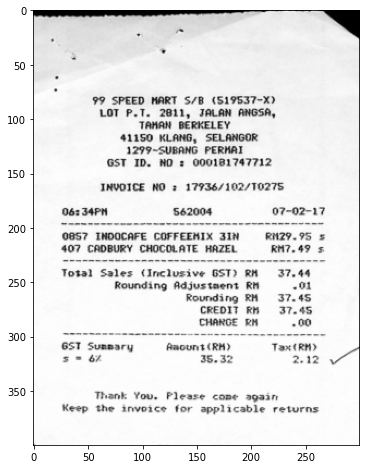

Labels: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR
Pred: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1076-SUBANG PERDANA



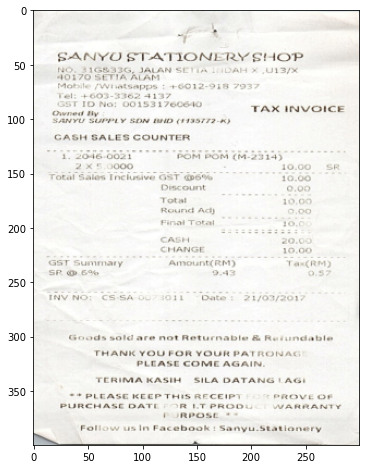

Labels: SANYU STATIONERY SHOP [NL] NO. 31G&33G, JALAN SETIA INDAH X ,U13/X 40170 SETIA ALAM
Pred: PASYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.



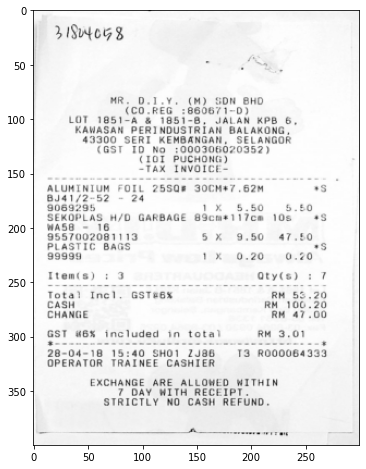

Labels: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Pred: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



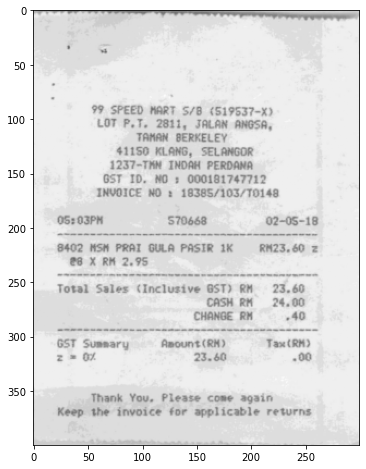

Labels: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1237-TMN INDAH PERDANA
Pred: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1214-JINJANG UTARA



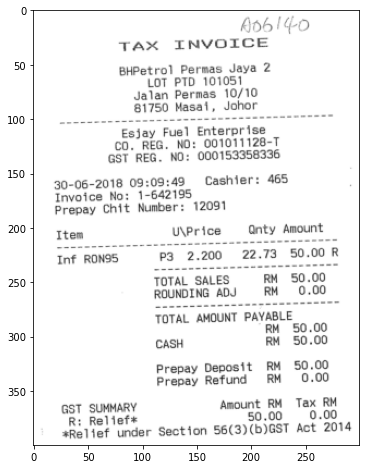

Labels: ESJAY FUEL ENTERPRISE [NL] LOT PTD 101051 JALAN PERMAS 10/10 81750 MASAI, JOHOR
Pred: BHPETROL PALEKBANG SDN BHD [NL] LOT PTD 182908 & PALEKBANG, JALAN SS21/60, DAMANSARA UTAMA PETALING JAYA 47400 SELANGOR



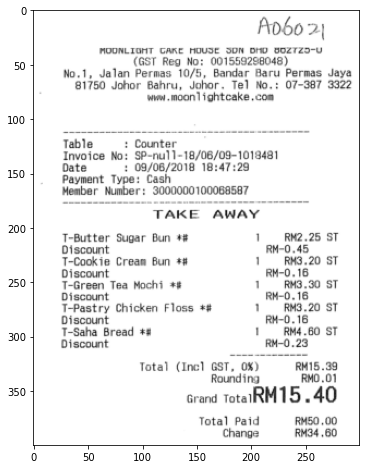

Labels: MOONLIGHT CAKE HOUSE SDN BHD [NL] NO.1, JALAN PERMAS 10/5, BANDAR BARU PERMAS JAYA 81750 JOHOR BAHRU, JOHOR.
Pred: PERNIAGAAN ZHENG HUI SDN BHD [NL] NO.1, JALAN PERMAS 10/5, BANDAR BARU PERMAS JAYA 81750 JOHOR BAHRU, JOHOR



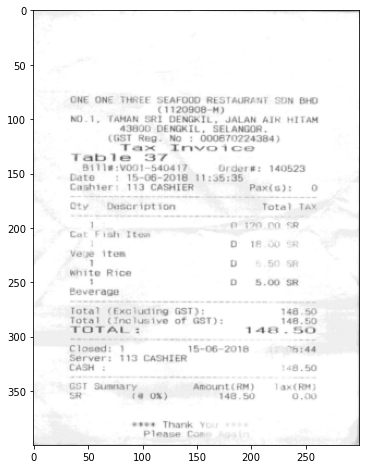

Labels: ONE ONE THREE SEAFOOD RESTAURANT SDN BHD [NL] NO.1, TAMAN SRI DENGKIL, JALAN AIR HITAM 43800 DENGKIL, SELANGOR.
Pred: CHEF LEE SDN BHD [NL] NO.1, JALAN SS21/60, DAMANSARA UTAMA, 47400 SHAH ALAM, SELANGOR.



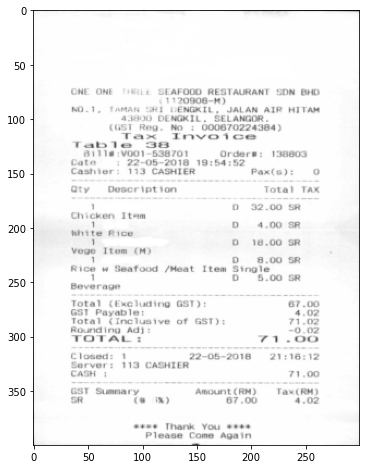

Labels: ONE ONE THREE SEAFOOD RESTAURANT SDN BHD [NL] NO. 1, TAMAN SRI DENGKIL, JALAN AIR HITAM 43800 DENGKIL, SELANGOR.
Pred: GOLDEN SCOOP SDN BHD [NL] NO.1, JALAN SS21/60, DAMANSARA UTAMA PETALING JAYA 47400 SELANGOR



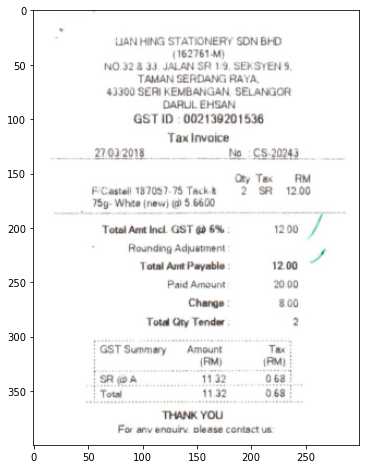

Labels: LIAN HING STATIONERY SDN BHD [NL] NO.32 & 33, JALAN SR 1/9, SEKSYEN 9, TAMAN SERDANG RAYA, 43300 SERI KEMBANGAN, SELANGOR DARUL EHSAN
Pred: LIAN HING STATIONERY SDN BHD [NL] NO.32 & 33, JALAN SR 1/9, SEKSYEN 9, TAMAN SERDANG RAYA, 43300 SERI KEMBANGAN, SELANGOR DAR



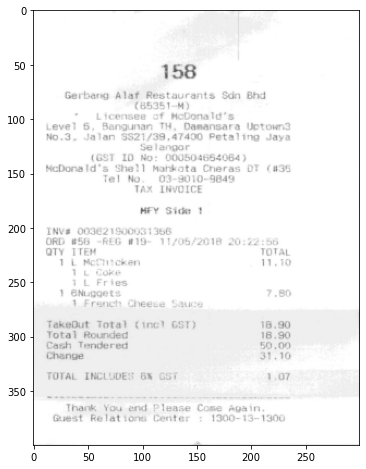

Labels: GERBANG ALAF RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39,47400 PETALING JAYA SELANGOR
Pred: GERBANG ALAF RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39,47400 PETALING JAYA SELANGOR



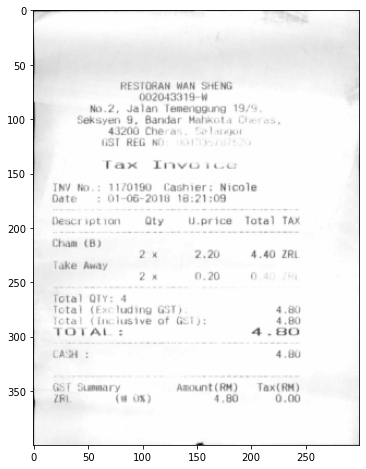

Labels: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Pred: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR



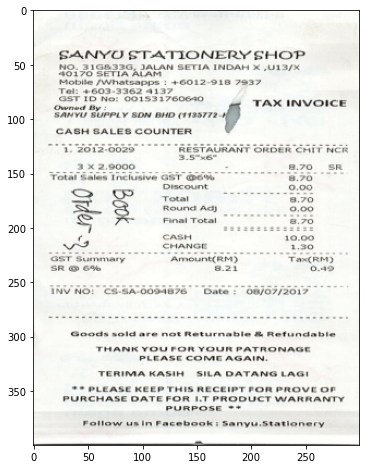

Labels: SANYU STATIONERY SHOP [NL] NO. 31G&33G, JALAN SETIA INDAH X ,U13/X 40170 SETIA ALAM
Pred: PASYARIKAT PERNIAGAAN GIN KEE [NL] NO.53 JALAN PERMAS 9/5 BANDAR BARU PERMAS JAYA 81750 JOHOR BAHRU



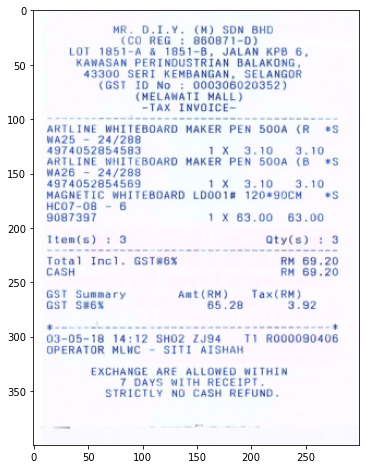

Labels: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Pred: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



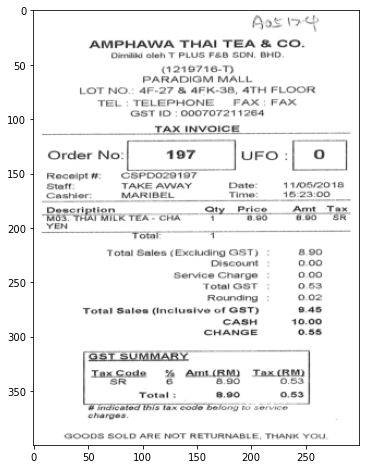

Labels: DIMILIKI OLEH T PLUS F&B SDN. BHD. [NL] PARADIGM MALL LOT NO.: 4F-27 & 4FK-38, 4TH FLOOR
Pred: AMPANG 210 FIRST CITY PARKING SDN BHD [NL] LOT NO. : G23 & 47400, GIANT KELANG 210.



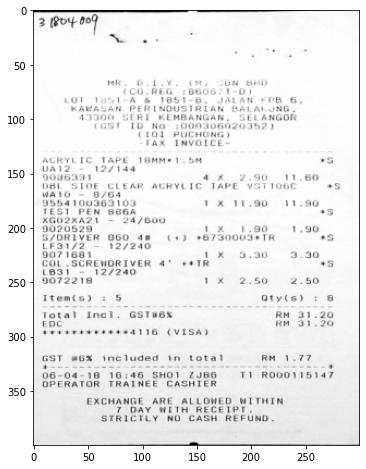

Labels: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Pred: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



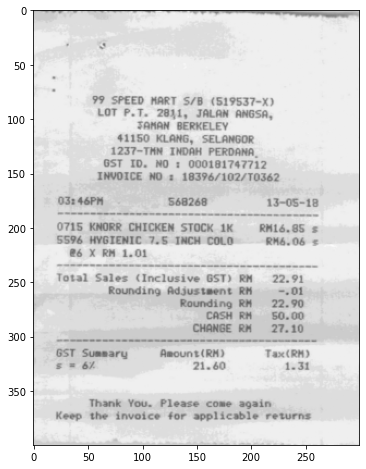

Labels: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1237-TMN INDAH PERDANA
Pred: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1076-TMN SUBANG PERDANA



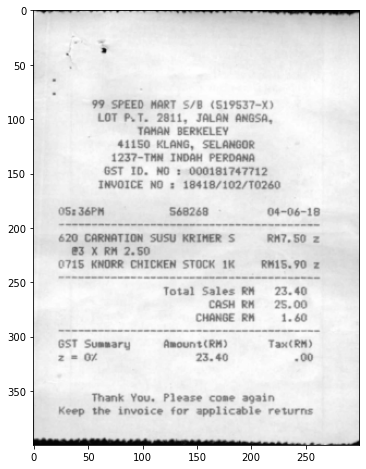

Labels: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1237-TMN INDAH PERDANA
Pred: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1076-TMN INDAH PERUSA



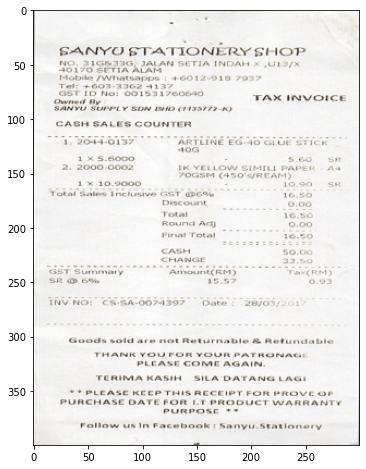

Labels: SANYU STATIONERY SHOP [NL] NO. 31G&33G, JALAN SETIA INDAH X ,U13/X 40170 SETIA ALAM
Pred: SUNFISH [NL] NO.12, JALAN SETIA INDAH (X) U13/X, SETIA ALAM, SEKSYEN U13,



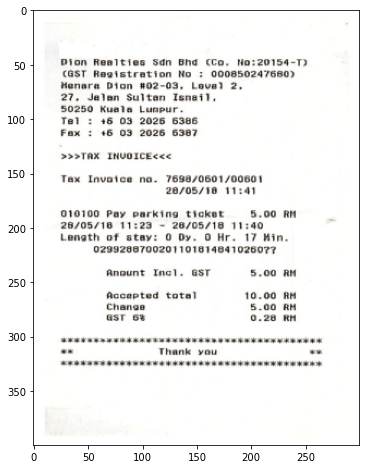

Labels: DION REALTIES SDN BHD [NL] MENARA DION #02-03, LEVEL 2, 27, JALAN SULTAN ISMAIL, 50250 KUALA LUMPUR.
Pred: SUPER MARKETING SDN BHD [NL] LOT 11995, BATU 2, JALAN KAPAR 41400 KLANG, SELANGOR



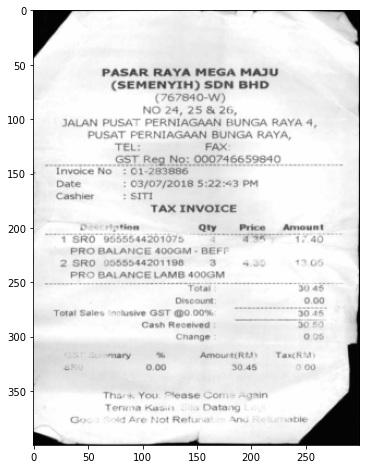

Labels: PASAR RAYA MEGA MAJU (SEMENYIH) SDN BHD [NL] NO 24, 25 & 26, JALAN PUSAT PERNIAGAAN BUNGA RAYA 4, PUSAT PERNIAGAAN BUNGA RAYA,
Pred: PASARAYA BORONG PINTAR SDN BHD [NL] NO.128G, JLN SUBANG JASA 3, JALAN PJSAR, PERINDUSTRIAN BUKIT RAYA, 43300 PETALING JAYA, SEL



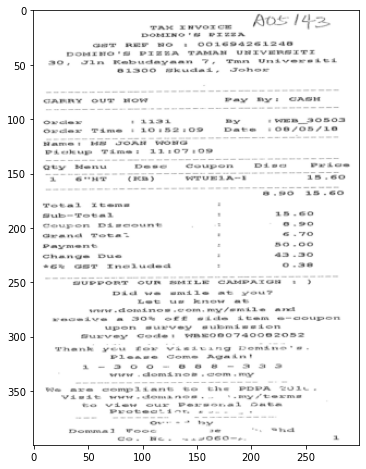

Labels: DOMINO'S PIZZA TAMAN UNIVERSITI [NL] 30, JLN KEBUDAYAAN 7, TMN UNIVERSITI 81300 SKUDAI, JOHOR
Pred: TEO HENG STATIONERY & BOOKS [NL] NO.53,JALAN BESAR,45600 BATANG BERJUNTAI SELANGOR DARUL EHSAN



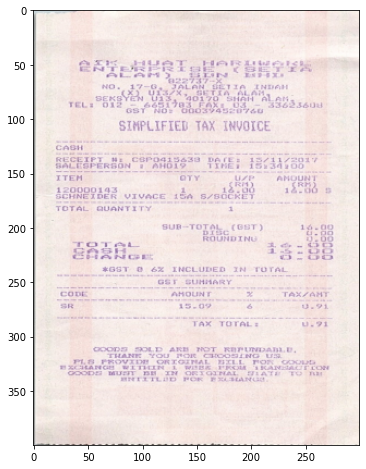

Labels: AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD [NL] NO. 17-G, JALAN SETIA INDAH (X) U13/X, SETIA ALAM, SEKSYEN U13, 40170 SHAH ALAM,
Pred: AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD [NL] NO. 17-G, JALAN SETIA INDAH (X) U13/X, SETIA ALAM, SEKSYEN U13,



In [26]:
batch = next(iter(test_dl))
batch[0] = batch[0].cuda()

test_model.eval()

with torch.no_grad():
    pred_tokens = test_model(batch)

decoded_preds = [test_model.tokenizer.decode(t) for t in pred_tokens]

images, labels, tokens = batch

for image, label, pred in zip(images, labels, decoded_preds):
    plt.figure(figsize=(6, 8))
    plt.imshow(((image.squeeze(0).cpu().numpy().transpose(1, 2, 0)/2+1)))
    plt.show()
    print(f'Labels: {label}\nPred: {pred}\n')

## Observações

**1. Abordagens usando pre-treino em OCR artificiais produzidos por texto (Como feito na Aula 7) foram avaliados, mas não demostraram grande vantagem para o problema.**

2. Acredito que o uso de um pre-treino usando mais imagens  o dataset RVL-CDIP como feito no artigo da LayoutLM possa melhorar a performance uma vez que o data-set de usado aqui é muito pequeno.

3. O principal problema foi o tamanho do data-set que é pequeno fazendo que o modelo tenha overfitting muito facilmente.